# Estimating a model with a known number of bumps

This section will show you how to estimate a single HsMM model with a given number of bump. We will generate data as in the demo on the github main page but we'll make it harder to find for the HsMM algortihm by reducing the amplitude of the generating sources.

In [2]:
## Importing the package
import hsmm_mvpy as hsmm

## Imports and code specific to the simulation (see tutorial 3 and 4 for real data)
import os
import numpy as np
from scipy.stats import gamma
from hsmm_mvpy import simulations
import matplotlib.pyplot as plt 
import seaborn as sns

cpus = 10 # For multiprocessing, usually a good idea to use multiple CPus as long as you have enough RAM

## Parameters for the simulations
frequency, amplitude = 10., .025e-6 
shape = 2#shape of the gamma distribution

#Storing electrode position, specific to the simulations
positions = simulations.simulation_positions()
sfreq = simulations.simulation_sfreq()#sampling freqency of the simulated data
resample_freq = sfreq
all_source_names = simulations.available_sources()#all brain sources you can play with
n_events = 50 #Number of trials to simulate

# Randomly specify the transition events
n_bumps = np.random.choice(np.arange(4,11))#Below four is not very interesting, more than 11 is slow
name_sources = np.random.choice(all_source_names,n_bumps+1, replace=False)#randomly pick source without replacement
times = np.random.uniform(50,300,n_bumps+1)/shape#randomly pick average times in millisecond between the events

sources = []
for source in range(len(name_sources)):
    source_amp = amplitude
    if source == len(name_sources)-1:
        source_amp = 1e-20
    sources.append([name_sources[source], frequency, amplitude, \
                      gamma(shape, scale=times[source], loc=25)])
    
colors = sns.color_palette(None, len(name_sources))

file = 'dataset_tutorial2-bis' #Name of the file to save

#Simulating and recover information on electrode location and true time onset of the simulated bumps
files = simulations.simulate(sources, n_events, cpus,file, overwrite=False)
generating_events = np.load(files[1])
number_of_sources = len(np.unique(generating_events[:,2])[1:])#one trigger = one source
random_source_times = np.reshape(np.diff(generating_events[:,0], prepend=0),(n_events,number_of_sources+1))[:,1:]#By-trial generated bump times

#Reading the necessary info to read the EEG data
resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}
resp_id = {'response':resp_trigger}
events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

# Reading the data
eeg_dat = hsmm.utils.read_mne_EEG(files[0], event_id, resp_id, resample_freq, events_provided=events, verbose=False)
hsmm_dat = hsmm.utils.transform_data(eeg_dat.data, apply_standard=False, n_comp=number_of_sources-1)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Reading labels from parcellation...
   read 34 labels from /home/gweindel/mne_data/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 34 labels from /home/gweindel/mne_data/MNE-sample-data/subjects/sample/label/rh.aparc.annot
./dataset_tutorial2-bis_raw.fif exists no new simulation performed
Processing participant ./dataset_tutorial2-bis_raw.fif
Reading 0 ... 297568  =      0.000 ...   495.439 secs...
Creating epochs based on following event ID :[ 1 10]
N trials without response event: 0
Applying reaction time trim to keep RTs between 0.001 and 5 seconds
50 RTs kept of 50 clean epochs
50 trials were retained for participant ./dataset_tutorial2-bis_raw.fif
End sampling frequency is 600.614990234375 Hz


HsMM-MVpy uses classes to instantiate fit of HsMM models. Therefore before estimating a model one needs to declare an instance of the HsMM class by specifying the data, the sampling frequency of the data as well as several parmeters such as the bump width (in milliseconds) and how many CPU to use.

In [3]:
init = hsmm.models.hsmm(hsmm_dat, sfreq=eeg_dat.sfreq, bump_width=50, cpus=cpus)#Initialization of the model

Once the class has been initiated, the function ```fit_single()``` can be used to estimate one HsMM model with a specified number of bumps

## Direct estimation
We can simply call the ```fit_single``` method from the hsmm class to estimate a given number of bump. The HsMM algorithm will then look for 4 bumps. Now the expectation maximization algorithm to fit the model is in this case sensitive to the starting points given to the stage duration. By default, the ```fit_single``` method uses a starting point where all bumps are equally distributed between 0 and the mean RT.

Estimating 8 bumps model with 1 starting point(s)
Parameters estimated for 8 bumps model


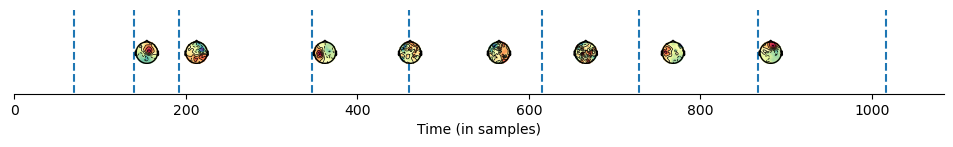

In [4]:
#Fitting
selected = init.fit_single(number_of_sources-1)#function to fit an instance of a 10 bumps model

#Visualizing
hsmm.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

Now launching a single model without additional starting points is not a good idea as often the default starting values of the expectation maximization algorithm will end up in a local minima. We need to use more starting points and we developed several methods for that
 

## Random method


A better idea is to run a single model with several starting points as can be declared in the ```single_fit()``` function, hereby an example with 100 random starting points:

Estimating 8 bumps model with 100 starting point(s)
Parameters estimated for 8 bumps model


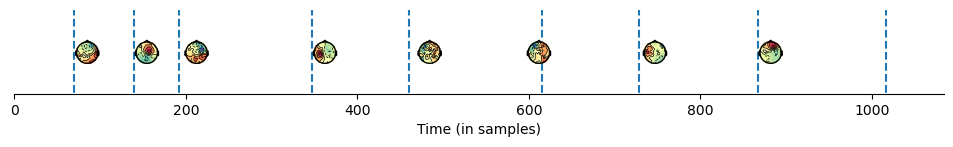

In [5]:
#Fitting
selected = init.fit_single(number_of_sources-1, method='random', starting_points=100)#function to fit an instance of a 4 bumps model
hsmm.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

But, by definition, the starting points are random so inducing a lot of redundancy and also taking the risk that some points in the parameter space remain unexplored.

## Grid search 
In an effort to circumvent these limitations we designed a function called ```grid_search``` which basically decomposes the mean RT into a grid with points. After having defined the grid, the function then generates all possible combination of 
        _n_ bump placements within this grid. It is faster than using random points (both should converge with enough starting points) but depending on the mean RT and the number 
        of bumps to look for, the number of combination can be really large. For this reason we also need to specify a maximum number of starting point. The ```grid_search```function will then scale the grid according to the maximum starting points number requested. Note that this method works nicely for :
- 1 bump models
- very high number of short bumps 

Estimating 8 bumps model with 500 starting point(s)
Initial number of possibilities is 26962557712029474678. Given a number of max iteration = 500: fitting 165 models based on all possibilities from grid search with a spacing of 78 samples and 13 points and durations of [ 78. 156. 234. 312.]
Parameters estimated for 8 bumps model


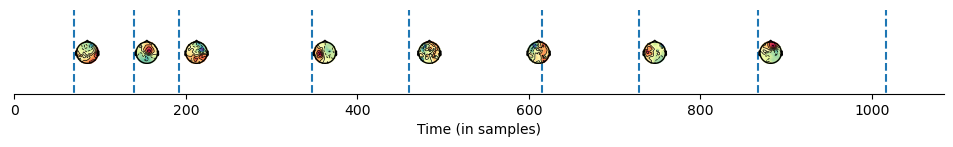

In [6]:
#Fitting
selected = init.fit_single(number_of_sources-1, method='grid', starting_points=500)#function to fit an instance of a 4 bumps model
hsmm.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, magnify=1,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

Works also but see how we needed to reduce the number of combinations by specifying ```starting_points=100```. The output shows us that the algorithm used a spacing of 80 samples between tested location and this could be suboptimal, even more if we had a longer mean RT. Ideally we want a method that looks for likelihood of a bump at any sample.

## Backward estimation

Now both solutions might not be enough for example if you are trying to fit a medium number of bumps, generating too many possibilties for grid search (which then decreases precision in the grid) or requesting too many random starting points. Therefore, an even better solution than random points is to estimate the maximal number of possible bumps.

The idea is that genuine bumps will necessarily be found at the expected locations in the maximal number of bump model and because the backward estimation method iteratively removes the weakest bump (in terms of likelihood), only the 'strongest' bumps remains even if there location would have been hard to find with a single fit and default starting values.
To do that we will use the ```backward_estimation()``` function. This function first estimate the max_bump solution (defined based on the bump width and the minimum reaction time) then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood (for more details see Borst & Anderson, [2021](http://jelmerborst.nl/pubs/ACTR_HsMM_MVPA_BorstAnderson_preprint.pdf)) and repeat this until the 1 bump solution. 

In [7]:
%%time 
bests = init.backward_estimation(max_bumps=15, min_bumps=number_of_sources-2)

Estimating all solutions for maximal number of bumps (15) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 14 number of bumps
Estimating all solutions for 13 number of bumps
Estimating all solutions for 12 number of bumps
Estimating all solutions for 11 number of bumps
Estimating all solutions for 10 number of bumps
Estimating all solutions for 9 number of bumps
Estimating all solutions for 8 number of bumps
CPU times: user 16.5 s, sys: 23.6 s, total: 40 s
Wall time: 1min 1s


Here we plot the resulting solutions going from the maximal possible number of bumps that fit into the minimum RT given a minimum duration of 25ms in this example 

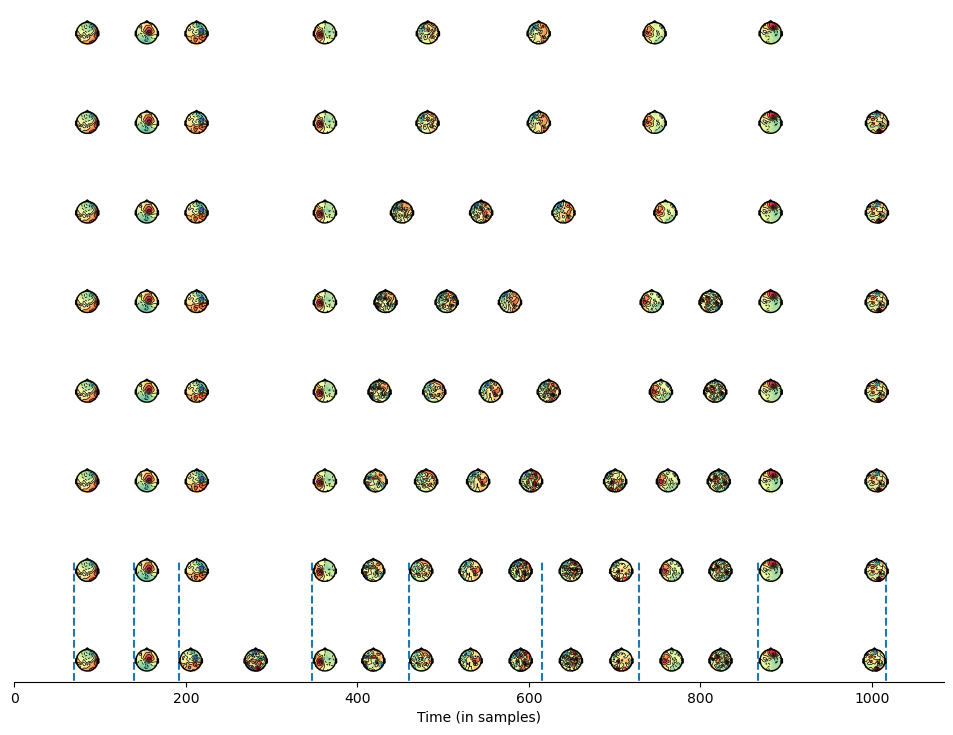

In [8]:
hsmm.visu.plot_topo_timecourse(eeg_dat, bests, positions, init, sensors=False, ydim='n_bumps',
                    times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

And from these solutions we can then select the number of bumps we wanted to estimate:

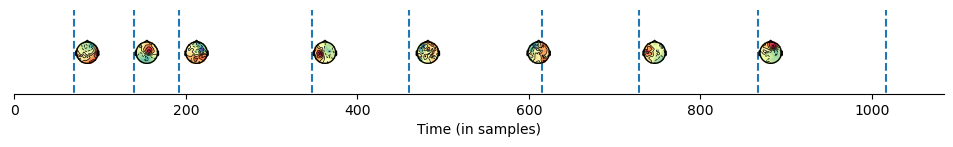

In [9]:
selected = bests.sel(n_bumps=number_of_sources-1)
hsmm.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, sensors=False,
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

Now the downside is that we are still unsure about whether we included all possible starting point in the mix and this method can turn bad with 1) long RTs and therefore a lot of bumps to fit and long computation times and 2) if there is a big difference between the minimum RT (determining the maximum number of bumps) and the mean RT (all possible locations of these bumps). 

Therefore this approach can be used in combination with an automatic way of finding the number of bumps needed to fit the data:

## Cumulative bump fit

Instead of fitting an _n_ bump model, this method fits a 2 bump model using each sample from the time 0 (stimulus onset) to the mean RT. Therefore it tests for the landing point of the expectation maximization algorithm given each sample as starting point and the likelihood associated with this landing point. As soon as an estimated bump exceeds the previous one by a given ```threshold```, the funtions fits a _n+1_ bump model and uses the next samples in the RT.

In [10]:
estimates = init.fit(threshold=1, verbose=False)

  0%|          | 0/1015 [00:00<?, ?it/s]

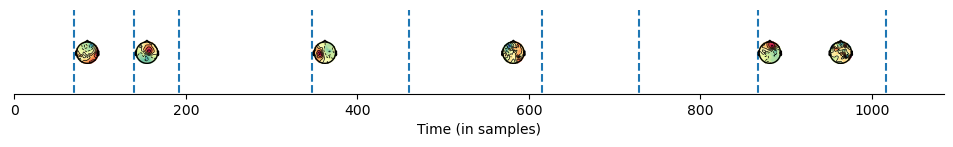

In [11]:
hsmm.visu.plot_topo_timecourse(eeg_dat, estimates, positions, init, 
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

In an explorative way we can play around that value to see how much bumps we can find.

In [12]:
estimates = init.fit(threshold=.01, verbose=False)

  0%|          | 0/1015 [00:00<?, ?it/s]

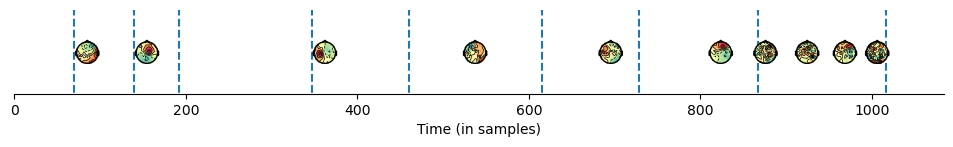

In [13]:
hsmm.visu.plot_topo_timecourse(eeg_dat, estimates, positions, init, 
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

Not perfect but we're getting there. Now we can use this model with a very small threshold as input to the backward estimation.

In [14]:
%%time 
bests = init.backward_estimation(max_fit=estimates, min_bumps=number_of_sources-2)

Estimating all solutions for 9 number of bumps
Estimating all solutions for 8 number of bumps
CPU times: user 493 ms, sys: 515 ms, total: 1.01 s
Wall time: 12.6 s


Here we plot the resulting solutions going from the maximal possible number of bumps that fit into the minimum RT given a minimum duration of 25ms in this example 

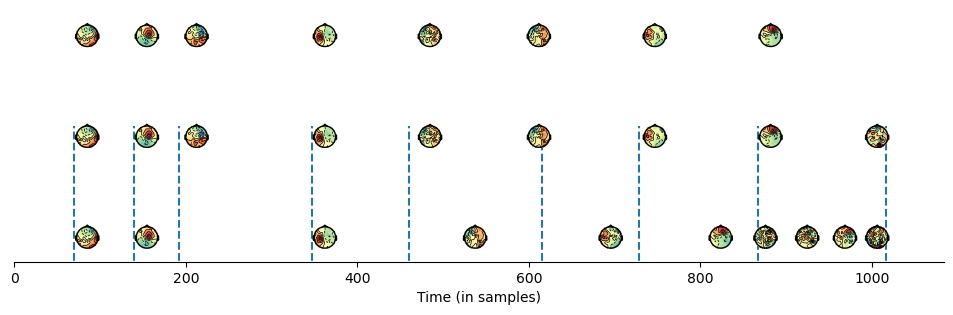

In [15]:
hsmm.visu.plot_topo_timecourse(eeg_dat, bests, positions, init, sensors=False, ydim='n_bumps',
                    times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

And look at the expected number of bumps

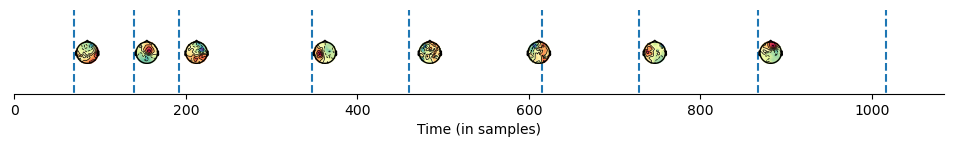

In [16]:
selected = bests.sel(n_bumps=number_of_sources-1)

hsmm.visu.plot_topo_timecourse(eeg_dat, selected, positions, init, 
                                times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

# Data saving

Once finished we can save all the fitted models using the dedicated command

In [17]:
hsmm.utils.save_fit(estimates, 'selected.nc')

selected.nc saved


And load the same way

In [18]:
estimates = hsmm.utils.load_fit('selected.nc')

Or even only save the estimated event probabilities 

In [19]:
hsmm.utils.save_eventprobs(estimates.eventprobs, 'selected_eventprobs.nc')

Saved at selected_eventprobs.nc
